<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/NLP/KGQA/Spacy_Knowledge_graph_wiki_music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Spacy knowledge graph



---



In [42]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [43]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [4]:
#!wget https://drive.google.com/u/0/uc?id=1yuEUhkVFIYfMVfpA_crFGfSeJLgbPUxu&export=download

In [44]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("/content/wiki_sentences_v2.csv")

candidate_sentences.shape

(4318, 1)

In [46]:
candidate_sentences['sentence'].sample(5)

185                                        ; with a digital version released 22 january.
1161                                      toto gangs up his cronies to trash karamveer .
2760                                   other film directors have attended a film school.
3169                           it was the most successful bollywood concert at the time.
2003    it is the highest-grossing animated film in south korea, denmark, and venezuela.
Name: sentence, dtype: object

In [47]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... amod
d823 ... pobj


In [48]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [49]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [50]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:38<00:00, 111.79it/s]


In [51]:
entity_pairs[0:20]

[['connie', 'own'],
 ['later  woman', 'distance'],
 ['christian', 'then  elder'],
 ['temple', 'fire'],
 ['outside  cult', 'him'],
 ['it', 'religious  awakening'],
 ['c. mackenzie', 'craig cast'],
 ['later craig di francia', 'action cast'],
 ['sebastian  maniscalco', 'later paul ben cast'],
 ['we', 'just  film'],
 ['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

In [52]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [53]:
get_relation("John completed the task")

'completed'

In [54]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:37<00:00, 115.08it/s]


In [55]:
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
are               71
were              71
released          40
's                38
composed by       35
has               31
became            31
have              31
become            29
released in       27
included          26
called            22
produced          22
made              20
had               20
considered        20
be                18
been              18
used              17
scheduled         17
stars             16
directed by       16
written by        15
wrote             14
set               14
produced by       14
hired             14
went              13
introduced in     13
received          13
wanted            12
began             11
won               11
began in          11
gave              10
sold              10
features          10
produced in        9
used in            9
shot in            9
known as           9
opened             9
includes           9
directed     

In [56]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [70]:
kg_df.sample(10)

,source,target,edge
1751,bollywood films,former soviet russian,are popular
3514,rating,2011,is
263,examples,all r house,include
3893,meanwhile kuntala,pindaris,attacked by
1286,newcomers dacre montgomery,then ludi jason,cast as
3447,he,bond,created
793,look,lenses,is
1819,2013 film critics,"$ 82,000",make
581,film,july,released on
4234,finch,considerable prominence,responded


In [58]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

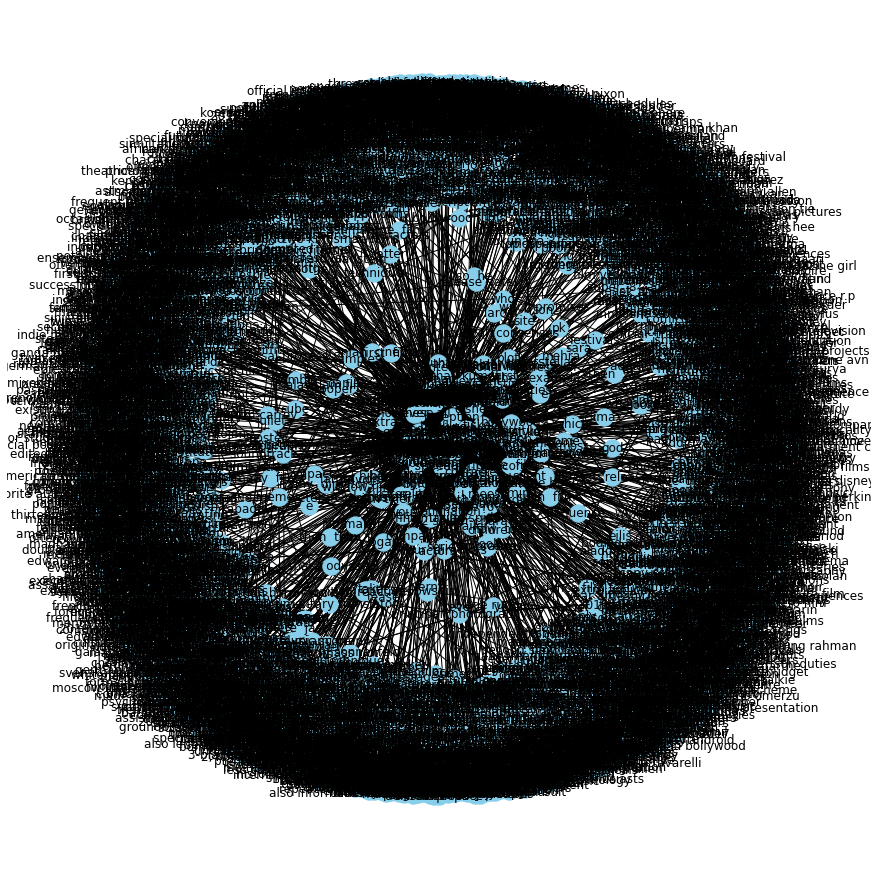

In [59]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

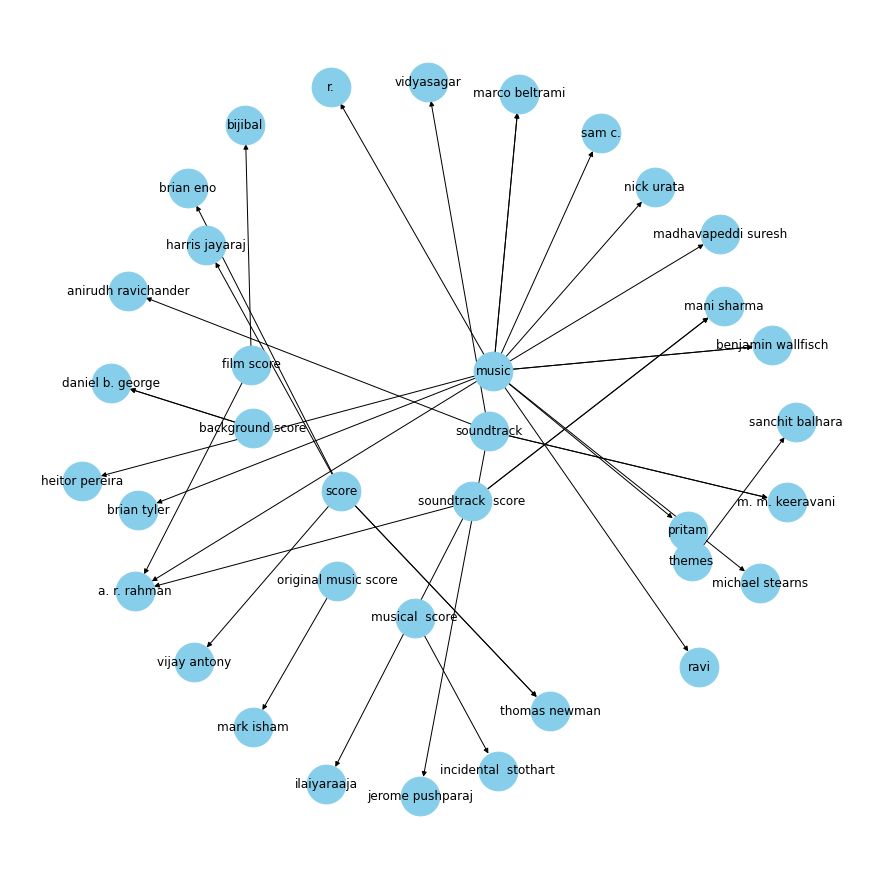

In [60]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

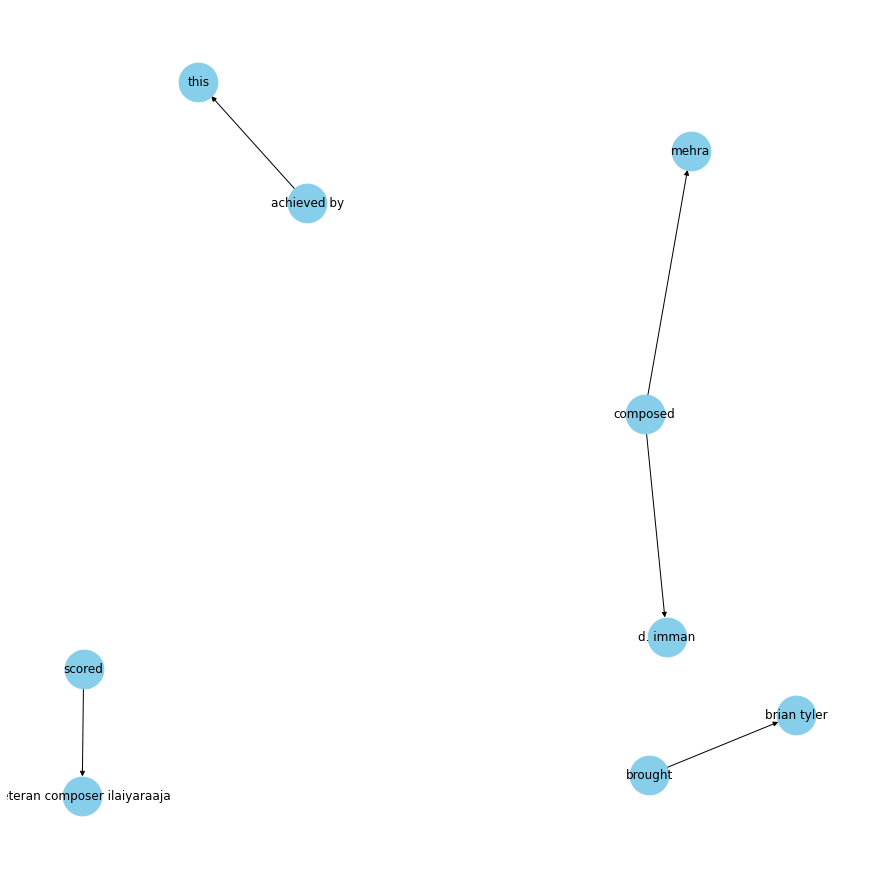

In [61]:
G=nx.from_pandas_edgelist(kg_df[kg_df['target']=="music"], "edge", "source", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

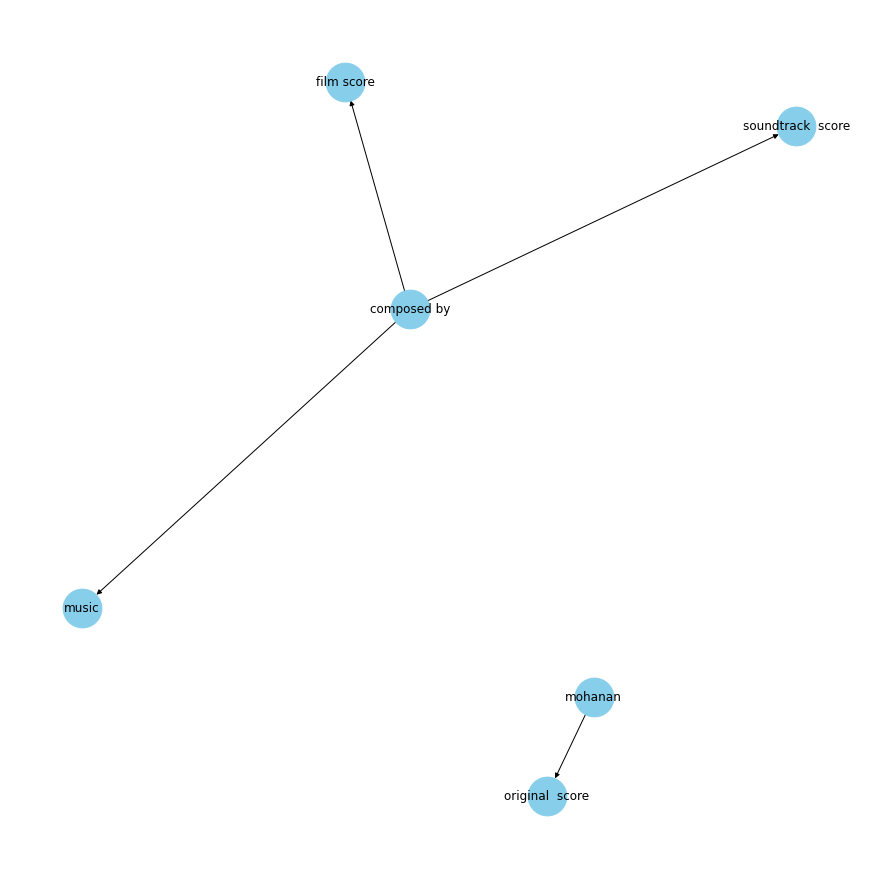

In [62]:
G=nx.from_pandas_edgelist(kg_df[kg_df['target']=="a. r. rahman"], "edge", "source", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

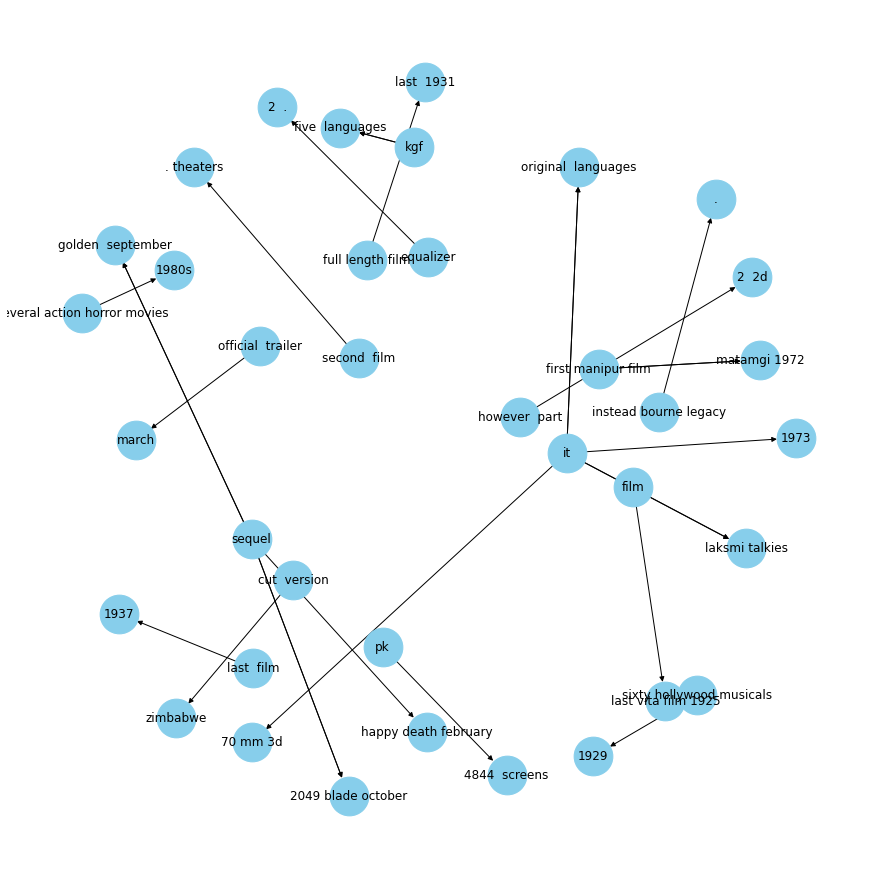

In [63]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [64]:
kg_df

,source,target,edge
0,connie,own,decides
1,later woman,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with
...,...,...,...
4313,confidencial,negatively film,responded
4314,le parisien,five star rating,gave
4315,museum collection,"37,000 film titles",includes
4316,predecessor,historical film 1946,was


## Let us extract information from the knowledge graph

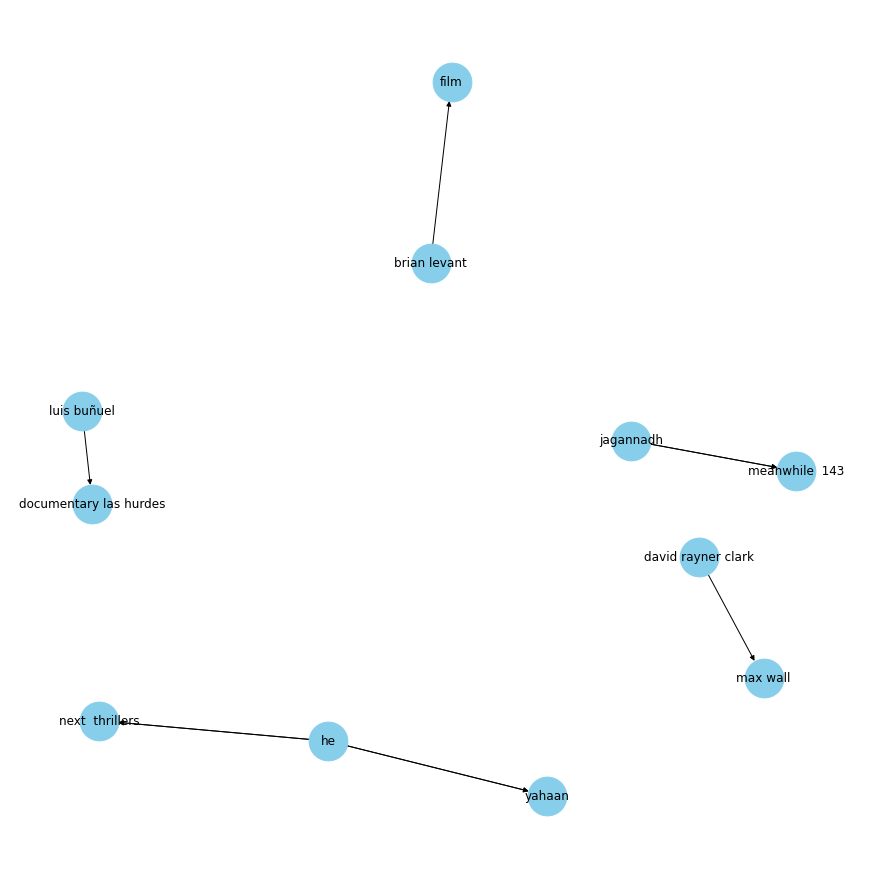

In [65]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == "directed"], "source", "target", edge_attr=True, create_using = nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

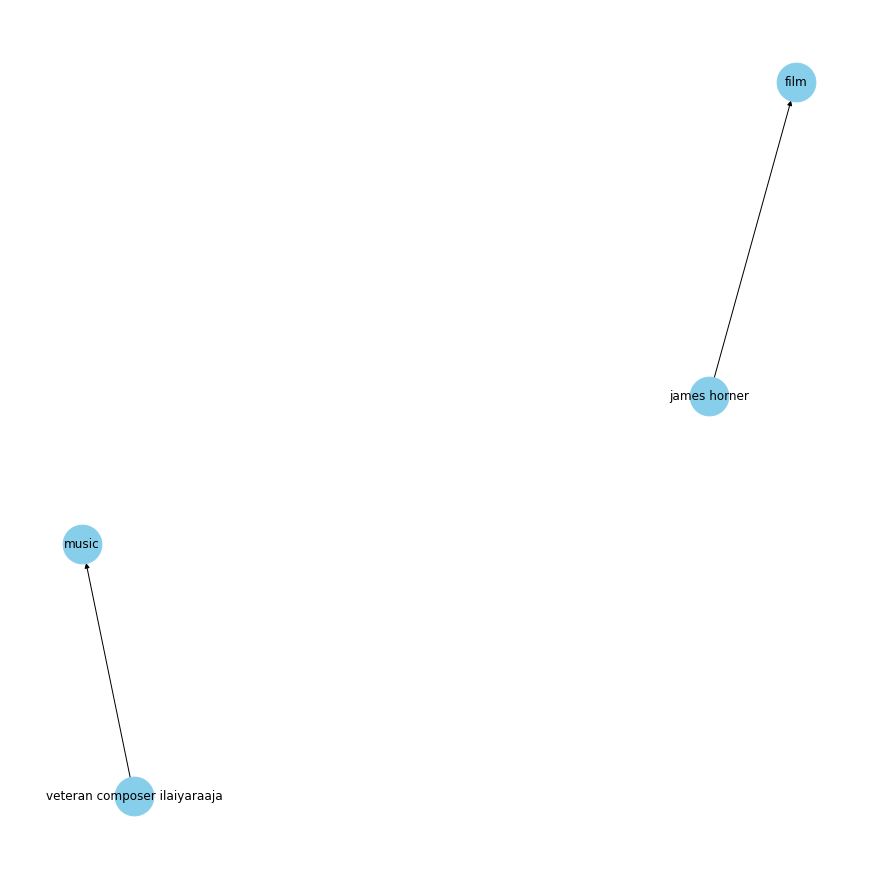

In [67]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="scored"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()